# Exercise 1

In [410]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
import pandas as pd
import scipy
from scipy import io
from tqdm.notebook import tqdm
from numpy import random, arange
from numpy.fft import rfft, rfftfreq
from scipy.signal import butter, lfilter
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import random
import seaborn as sns


## Understand the dataset


This dataset consists of two groups of participants (groups 1 and 2).  For each participant in both groups, there are three types of. mat files, PPG data, True BMP, and Labels. PPG data contains two-channel PPG signals(`PPG1`,`PPG2`), three axis acceleration signals(`a_x`,`a_y`,`a_z`), and one-channel ECG signals(`ECG`). True BMP indicates the true heart rate calculated from `ECG` signal from PPG data. And the Labels tell if the difference between the estimation and the ground truth is large than 5(1:less than 5, 0: large than 5).

There is no sufficient data for sport type 01 in both groups, so I decide to only investigate the influence of different types of sports(eg: running and forearm and uparm movements) instead of the sports intensity on heart rate. Since I don't take into account health condition for this analysis, the data from the 8th person in group 2 with abnormal heart rhythm and blood pressure is excluded.

Because there is no `ECG` feature in PPG data for group 2 and `ECG` can be represented by `BPM0`, I exclude `ECG` data from my analysis.

Having a look at the dataset

In [526]:
#load PPG data
url='Exercise 1/PPG data/Group 1/DATA_2_TYPE02.mat'
features_struct = scipy.io.loadmat(url)
features = features_struct['sig']
dfdata = pd.DataFrame(features)
data=dfdata.T
data.rename(columns={0:'ECG', 1:'PPG1', 2:'PPG2',3:'a_x',4:'a_y',5:'a_z'}, inplace = True)
data 

,ECG,PPG1,PPG2,a_x,a_y,a_z
0,-173.0,-88.0,-17.5,-0.1404,0.1482,0.6630
1,-168.5,-85.5,-18.0,-0.1326,0.1638,0.6318
2,-164.5,-83.0,-19.0,-0.1170,0.1638,0.6240
3,-158.0,-80.0,-19.0,-0.1092,0.1716,0.6162
4,-148.0,-77.0,-19.5,-0.1092,0.1716,0.6240
...,...,...,...,...,...,...
37845,-382.5,41.5,23.0,-0.0858,0.8034,0.4056
37846,-381.5,35.0,18.5,-0.0936,0.8112,0.4056
37847,-378.0,28.5,13.5,-0.0858,0.8190,0.3978
37848,-378.5,23.0,10.5,-0.1014,0.8268,0.3822


In [527]:
# Check the basic information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37850 entries, 0 to 37849
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ECG     37850 non-null  float64
 1   PPG1    37850 non-null  float64
 2   PPG2    37850 non-null  float64
 3   a_x     37850 non-null  float64
 4   a_y     37850 non-null  float64
 5   a_z     37850 non-null  float64
dtypes: float64(6)
memory usage: 1.7 MB


In [528]:
data.describe()

,ECG,PPG1,PPG2,a_x,a_y,a_z
count,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000,37850.000000
mean,-278.474927,-0.707966,3.292404,-0.244173,0.823529,0.404672
std,129.132680,57.130225,40.677968,0.413588,0.840990,0.590413
min,-1024.000000,-270.000000,-218.500000,-2.067000,-1.107600,-1.326000
25%,-323.375000,-30.500000,-22.000000,-0.475800,0.327600,0.046800
50%,-279.500000,-1.000000,4.500000,-0.187200,0.678600,0.522600
75%,-213.000000,33.500000,30.000000,0.000000,1.115400,0.787800
max,227.500000,208.500000,164.000000,0.912600,3.985800,2.394600


In [530]:
#load and merge BPM0 and Labels data
url_bpmo='Exercise 1/True BPM/Group 1/DATA_2_TYPE02_BPMtrace'
features_struct = scipy.io.loadmat(url_bpmo)
features = features_struct['BPM0']
dfBPM0 = pd.DataFrame(features)
dfBPM0.rename(columns={0:'BPM0'}, inplace = True)
      
url_label='Exercise 1/Labels/Group 1/Labels_DATA_2_TYPE02'
features_struct = scipy.io.loadmat(url_label)
features = features_struct['Labels']
dfLabels = pd.DataFrame(features)
dfLabels.rename(columns={0:'Labels'}, inplace = True)
        
result=pd.concat([dfBPM0,dfLabels], axis=1)
result

,BPM0,Labels
0,84.745763,1
1,89.771491,0
2,92.592593,1
3,88.996764,1
4,84.364454,0
...,...,...
143,141.509434,1
144,140.332640,1
145,138.461538,1
146,136.802575,1


## Feature engineering


I apply a bandpass filter between 0.4 and 4 Hz on two PPG signals and then standardize the dataset. Considering that all signals were sampled at 125 Hz and the BMP value was recorded in every 8-second time window with 6-second overlapping. I create a 8-second sequence window for PPG data so that there are 125*8=1000 rows in each sequence. Some statistical values, such as mean and skewness, can be extracted from the sequence.

In [411]:
# Build a bandpass filter function 
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

(0.0, 6.0, 0.0, 1000000.0)

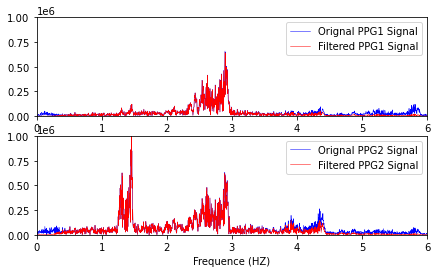

In [412]:
# An example to show the results of before and after applying bandpass filter
features_struct = scipy.io.loadmat('Exercise 1/PPG data/Group 1/DATA_12_TYPE02.mat') 
features = features_struct['sig']
data = pd.DataFrame(features).T

x1=data.loc[:,1]
x2=data.loc[:,2]

fs = 125.

plt.subplot(2,1,1)
hat_x1 = rfft(x1)
freqs = rfftfreq(x1.size, 1 / fs)
plt.plot(freqs, abs(hat_x1), 'b',linewidth=0.5,label='Orignal PPG1 Signal')

lowcut, highcut = 0.4, 4.
x1 = butter_bandpass_filter(x1, lowcut, highcut, fs, order=4)
hat_x1_fil = rfft(x1)
plt.plot(freqs, abs(hat_x1_fil), 'r',linewidth=0.5,label='Filtered PPG1 Signal')


plt.xlabel('Frequence (HZ)')
plt.legend()
x_min, x_max, y_min, y_max = 0, 6, 0, 1e6
plt.axis([x_min, x_max, y_min, y_max])


plt.subplot(2,1,2)

hat_x2 = rfft(x2)
freqs = rfftfreq(x2.size, 1 / fs)
plt.plot(freqs, abs(hat_x2), 'b',linewidth=0.5, label='Orignal PPG2 Signal')

lowcut, highcut = 0.4, 4.
x2 = butter_bandpass_filter(x2, lowcut, highcut, fs, order=4)
hat_x2_fil = rfft(x2)
plt.plot(freqs, abs(hat_x2_fil), 'r',linewidth=0.5,label='Filtered PPG2 Signal')


plt.xlabel('Frequence (HZ)')
plt.legend()
x_min, x_max, y_min, y_max = 0, 6, 0, 1e6
plt.axis([x_min, x_max, y_min, y_max])

In [413]:
#Build a sequence function. Extract specific computational features for each sequence, such as mean, skewness.
def create_sequences(input_data, sequence_length, sliding_length):
    result = []
    data_size = len(input_data)
    for i in tqdm(range(0,data_size - sequence_length, sliding_length)):
        sequence = input_data[i:i+sequence_length]
        avg_PPG1=np.mean(sequence['PPG1'])
        avg_PPG2=np.mean(sequence['PPG2'])
        
        skewness_PPG1=skew(sequence['PPG1'])
        skewness_PPG2=skew(sequence['PPG2'])
        skewness_ax=skew(sequence['a_x'])
        skewness_ay=skew(sequence['a_y'])
        skewness_az=skew(sequence['a_z'])
        
        ExType=np.mean(sequence['ExType'])
        Person=np.mean(sequence['Person'])
        
        
               
        result.append((avg_PPG1,avg_PPG2,
                      skewness_PPG1,skewness_PPG2,skewness_ax,skewness_ay,skewness_az,
                      ExType,Person))
    return result

## Create my dataset

In this part, I pack all the function to load, combine and merge all data to create one integrated dataset.

### Group 1 

In [533]:
BPM0_Labels_group1= pd.DataFrame(columns=['BPM0', 'Labels'])
for i in range(2,13):
    if i==4 or i==11:
        url_bpmo='Exercise 1/True BPM/Group 1/DATA_{}_TYPE02_BPMtrace'.format(i)
        features_struct = scipy.io.loadmat(url_bpmo)
        features = features_struct['BPM0']
        dfBPM0 = pd.DataFrame(features)
        dfBPM0.rename(columns={0:'BPM0'}, inplace = True)
        dfBPM0.drop([len(dfBPM0)-1],inplace=True)

      
        url_label='Exercise 1/Labels/Group 1/Labels_DATA_{}_TYPE02'.format(i)
        features_struct = scipy.io.loadmat(url_label)
        features = features_struct['Labels']
        dfLabels = pd.DataFrame(features)
        dfLabels.rename(columns={0:'Labels'}, inplace = True)
        dfLabels.drop([len(dfLabels)-1],inplace=True)
        
        
        result=pd.concat([dfBPM0,dfLabels], axis=1)
       # print(len(result))
        BPM0_Labels_group1=pd.concat([BPM0_Labels_group1,result])
    else:
        url_bpmo='Exercise 1/True BPM/Group 1/DATA_{}_TYPE02_BPMtrace'.format(i)
        features_struct = scipy.io.loadmat(url_bpmo)
        features = features_struct['BPM0']
        dfBPM0 = pd.DataFrame(features)
        dfBPM0.rename(columns={0:'BPM0'}, inplace = True)
      
        url_label='Exercise 1/Labels/Group 1/Labels_DATA_{}_TYPE02'.format(i)
        features_struct = scipy.io.loadmat(url_label)
        features = features_struct['Labels']
        dfLabels = pd.DataFrame(features)
        dfLabels.rename(columns={0:'Labels'}, inplace = True)
        
        result=pd.concat([dfBPM0,dfLabels], axis=1)
       # print(len(result))
        BPM0_Labels_group1=pd.concat([BPM0_Labels_group1,result])

        

In [415]:
PPG_data_group1 = pd.DataFrame(columns=['avg_PPG1', 'avg_PPG2', 'skewness_PPG1','skewness_PPG2','skewness_ax',
                              'skewness_ay','skewness_az','ExType','Person'])
for i in range(2,13):
        url='Exercise 1/PPG data/Group 1/DATA_{}_TYPE02.mat'.format(i)
        features_struct = scipy.io.loadmat(url)
        features = features_struct['sig']
        dfdata = pd.DataFrame(features)
        data=dfdata.T
        data.rename(columns={0:'ECG', 1:'PPG1', 2:'PPG2',3:'a_x',4:'a_y',5:'a_z'}, inplace = True)
       
        #bandpass
        x1=data.loc[:,'PPG1']
        x2=data.loc[:,'PPG2']
        lowcut, highcut,fs = 0.4, 4.,125.
        x1 = butter_bandpass_filter(x1, lowcut, highcut, fs, order=4)
        x2 = butter_bandpass_filter(x2, lowcut, highcut, fs, order=4)
        data['PPG1']=x1
        data['PPG2']=x2
        
        #standardize PPG data
        data = (data-data.mean())/data.std() 
        
        #create Person ID,Excersice Type
        data['ExType']=1
        data['Person']=i
        
        #create sequence for every 8 seconds, calculate the feature in each sequence.
        data_sequences = create_sequences(data, 125*8, 125*2)
        
        #convert to dataframe and rename the features' name.
        data_clean=pd.DataFrame(data_sequences)
        data_clean.rename(columns={0:'avg_PPG1', 1:'avg_PPG2', 
                                   2:'skewness_PPG1',3:'skewness_PPG2',4:'skewness_ax', 5:'skewness_ay', 6:'skewness_az',
                                   7:'ExType',8:'Person'}, inplace = True)
        #data_clean.rename(columns={0:'avg1', 1:'avg2'})

        PPG_data_group1=pd.concat([PPG_data_group1,data_clean])


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

In [417]:
PPG_data_group1=PPG_data_group1.reset_index()
BPM0_Labels_group1=BPM0_Labels_group1.reset_index()
data_group1= pd.merge(PPG_data_group1, BPM0_Labels_group1, left_index=True, right_index=True)
data_group1=data_group1.drop(['index_x', 'index_y'], axis=1)

In [418]:
data_group1

,avg_PPG1,avg_PPG2,skewness_PPG1,skewness_PPG2,skewness_ax,skewness_ay,skewness_az,ExType,Person,BPM0,Labels
0,-0.003816,0.014058,0.219015,1.578261,1.587511,0.988141,-1.849938,1.0,2.0,84.745763,1
1,0.024221,-0.006587,0.091629,0.351287,1.219255,0.749639,-1.547673,1.0,2.0,89.771491,0
2,-0.011707,-0.002878,0.191656,0.267740,1.264487,1.011613,-1.733567,1.0,2.0,92.592593,1
3,-0.015859,-0.005135,0.394270,0.242040,1.208146,0.952046,-1.704713,1.0,2.0,88.996764,1
4,0.024076,-0.009483,0.290403,-0.147928,1.446360,1.352678,-1.958540,1.0,2.0,84.364454,0
...,...,...,...,...,...,...,...,...,...,...,...
1613,-0.001295,-0.003358,0.035671,-0.073319,0.363141,1.072499,-0.888732,1.0,12.0,159.066800,1
1614,-0.001006,-0.001752,0.046118,-0.003185,0.214388,-0.129224,1.096826,1.0,12.0,157.397700,1
1615,-0.001446,-0.005481,0.052955,0.161699,0.112810,0.059708,1.208456,1.0,12.0,156.250000,1
1616,0.004975,0.002917,0.001592,0.059514,0.130190,0.034907,1.292304,1.0,12.0,155.440400,1


### Group 2

In [534]:
BPM0_Labels_group2= pd.DataFrame(columns=['BPM0', 'Labels'])
for i in range(2,8):
    if i==4:
        url_bpmo='Exercise 1/True BPM/Group 2/True_S0{}_T02'.format(i)
        features_struct = scipy.io.loadmat(url_bpmo)
        features = features_struct['BPM0']
        dfBPM0 = pd.DataFrame(features)
        dfBPM0.rename(columns={0:'BPM0'}, inplace = True)
        dfBPM0.drop([len(dfBPM0)-1],inplace=True)

      
        url_label='Exercise 1/Labels/Group 2/Labels_TEST_S0{}_T02'.format(i)
        features_struct = scipy.io.loadmat(url_label)
        features = features_struct['Labels']
        dfLabels = pd.DataFrame(features)
        dfLabels.rename(columns={0:'Labels'}, inplace = True)
        dfLabels.drop([len(dfLabels)-1],inplace=True)
        
        
        result=pd.concat([dfBPM0,dfLabels], axis=1)
        #print(len(dfBPM0))
        BPM0_Labels_group2=pd.concat([BPM0_Labels_group2,result])
    else:
        url_bpmo='Exercise 1/True BPM/Group 2/True_S0{}_T02'.format(i)
        features_struct = scipy.io.loadmat(url_bpmo)
        features = features_struct['BPM0']
        dfBPM0 = pd.DataFrame(features)
        dfBPM0.rename(columns={0:'BPM0'}, inplace = True)

      
        url_label='Exercise 1/Labels/Group 2/Labels_TEST_S0{}_T02'.format(i)
        features_struct = scipy.io.loadmat(url_label)
        features = features_struct['Labels']
        dfLabels = pd.DataFrame(features)
        dfLabels.rename(columns={0:'Labels'}, inplace = True)
        
        
        result=pd.concat([dfBPM0,dfLabels], axis=1)
        #print(len(dfBPM0))
        BPM0_Labels_group2=pd.concat([BPM0_Labels_group2,result])
    
    

In [420]:
PPG_data_group2 = pd.DataFrame(columns=['avg_PPG1', 'avg_PPG2', 'skewness_PPG1','skewness_PPG2','skewness_ax',
                              'skewness_ay','skewness_az','ExType','Person'])
for i in range(2,8):
        url='Exercise 1/PPG data/Group 2/TEST_S0{}_T02'.format(i)
        features_struct = scipy.io.loadmat(url)
        features = features_struct['sig']
        dfdata = pd.DataFrame(features)
        data=dfdata.T
        data.rename(columns={0:'PPG1', 1:'PPG2',2:'a_x',3:'a_y',4:'a_z'}, inplace = True)
       
        
        x1=data.loc[:,'PPG1']
        x2=data.loc[:,'PPG2']
        lowcut, highcut,fs = 0.4, 4.,125.
        x1 = butter_bandpass_filter(x1, lowcut, highcut, fs, order=4)
        x2 = butter_bandpass_filter(x2, lowcut, highcut, fs, order=4)
        data['PPG1']=x1
        data['PPG2']=x2
        
        data = (data-data.mean())/data.std() 
        
        data['ExType']=2
        data['Person']=i+11
        
        data_sequences = create_sequences(data, 125*8, 125*2)
        
        data_clean=pd.DataFrame(data_sequences)
        data_clean.rename(columns={0:'avg_PPG1', 1:'avg_PPG2',
                                   2:'skewness_PPG1',3:'skewness_PPG2',4:'skewness_ax', 5:'skewness_ay', 6:'skewness_az',
                                   7:'ExType',8:'Person'}, inplace = True)
        #data_clean.rename(columns={0:'avg1', 1:'avg2'})

        PPG_data_group2=pd.concat([PPG_data_group2,data_clean])


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [531]:
PPG_data_group2=PPG_data_group2.reset_index()
BPM0_Labels_group2=BPM0_Labels_group2.reset_index()
data_group2= pd.merge(PPG_data_group2, BPM0_Labels_group2, left_index=True, right_index=True)
data_group2=data_group2.drop(['index_x', 'index_y'], axis=1)


In [424]:
data_group12= pd.concat([data_group1,data_group2])
#data_group12=data_group12.reset_index()
data_group12=data_group12.reset_index().drop(['index'], axis=1)

In [425]:
data_group12

,avg_PPG1,avg_PPG2,skewness_PPG1,skewness_PPG2,skewness_ax,skewness_ay,skewness_az,ExType,Person,BPM0,Labels
0,-0.003816,0.014058,0.219015,1.578261,1.587511,0.988141,-1.849938,1.0,2.0,84.745763,1
1,0.024221,-0.006587,0.091629,0.351287,1.219255,0.749639,-1.547673,1.0,2.0,89.771491,0
2,-0.011707,-0.002878,0.191656,0.267740,1.264487,1.011613,-1.733567,1.0,2.0,92.592593,1
3,-0.015859,-0.005135,0.394270,0.242040,1.208146,0.952046,-1.704713,1.0,2.0,88.996764,1
4,0.024076,-0.009483,0.290403,-0.147928,1.446360,1.352678,-1.958540,1.0,2.0,84.364454,0
...,...,...,...,...,...,...,...,...,...,...,...
2429,-0.015182,-0.004634,-0.022050,0.238752,0.607440,-1.163811,0.550118,2.0,18.0,133.648000,1
2430,0.032827,0.023971,-0.172497,0.275110,0.602911,-1.634080,0.308280,2.0,18.0,132.890000,1
2431,0.034776,0.007622,-0.508196,-0.179952,0.743247,-0.455686,1.137059,2.0,18.0,132.674000,1
2432,-0.059685,-0.066121,-0.410366,-0.091395,0.548308,-0.197472,0.812302,2.0,18.0,133.185000,1


## Apply machine learning models

In [426]:
import copy
new_df = copy.deepcopy(data_group12)

In [427]:
#apply one-hot encoding on 'ExType', 'Person'
one_hot_df = pd.get_dummies(new_df,columns=['ExType', 'Person'],drop_first=True)

In [535]:
one_hot_df

,avg_PPG1,avg_PPG2,skewness_PPG1,skewness_PPG2,skewness_ax,skewness_ay,skewness_az,BPM0,Labels,ExType_2.0,...,Person_9.0,Person_10.0,Person_11.0,Person_12.0,Person_13.0,Person_14.0,Person_15.0,Person_16.0,Person_17.0,Person_18.0
0,-0.003816,0.014058,0.219015,1.578261,1.587511,0.988141,-1.849938,84.745763,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.024221,-0.006587,0.091629,0.351287,1.219255,0.749639,-1.547673,89.771491,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.011707,-0.002878,0.191656,0.267740,1.264487,1.011613,-1.733567,92.592593,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.015859,-0.005135,0.394270,0.242040,1.208146,0.952046,-1.704713,88.996764,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.024076,-0.009483,0.290403,-0.147928,1.446360,1.352678,-1.958540,84.364454,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,-0.015182,-0.004634,-0.022050,0.238752,0.607440,-1.163811,0.550118,133.648000,1,1,...,0,0,0,0,0,0,0,0,0,1
2430,0.032827,0.023971,-0.172497,0.275110,0.602911,-1.634080,0.308280,132.890000,1,1,...,0,0,0,0,0,0,0,0,0,1
2431,0.034776,0.007622,-0.508196,-0.179952,0.743247,-0.455686,1.137059,132.674000,1,1,...,0,0,0,0,0,0,0,0,0,1
2432,-0.059685,-0.066121,-0.410366,-0.091395,0.548308,-0.197472,0.812302,133.185000,1,1,...,0,0,0,0,0,0,0,0,0,1


In [429]:
one_hot_df['Labels']=one_hot_df['Labels'].astype('int')

In [430]:
one_hot_df.columns

Index(['avg_PPG1', 'avg_PPG2', 'skewness_PPG1', 'skewness_PPG2', 'skewness_ax',
       'skewness_ay', 'skewness_az', 'BPM0', 'Labels', 'ExType_2.0',
       'Person_3.0', 'Person_4.0', 'Person_5.0', 'Person_6.0', 'Person_7.0',
       'Person_8.0', 'Person_9.0', 'Person_10.0', 'Person_11.0', 'Person_12.0',
       'Person_13.0', 'Person_14.0', 'Person_15.0', 'Person_16.0',
       'Person_17.0', 'Person_18.0'],
      dtype='object')

In [536]:
#Making test and train sets
x_cols=['avg_PPG1', 'avg_PPG2', 'skewness_PPG1', 'skewness_PPG2', 'skewness_ax',
       'skewness_ay', 'skewness_az', 'BPM0', 'ExType_2.0',
       'Person_3.0', 'Person_4.0', 'Person_5.0', 'Person_6.0', 'Person_7.0',
       'Person_8.0', 'Person_9.0', 'Person_10.0', 'Person_11.0', 'Person_12.0',
       'Person_13.0', 'Person_14.0', 'Person_15.0', 'Person_16.0',
       'Person_17.0', 'Person_18.0']

X=one_hot_df[x_cols]
y=one_hot_df['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### SVC

I apply SVC model and check the accuracy of the prediction with confusion matrix. It can be seen below that the accuracy is suprisingly high (0.9378), which means that there could be some hidden factors that need to be noticed. Then I find out the dataset is very imbalanced.This could be the reason for the high accuracy.

In [537]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [538]:
pred=clf.predict(X_test)

In [539]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)
accuracy

0.9378109452736318

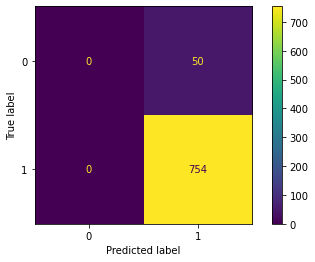

In [540]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

### Imbalanced data

It is found that only 6% of the data is labeled as 0, meaning the data is very imbalanced. The dataset is therefore resampled using function SMOTEENN() to balance the data, after which SVC is applied again. It turns out that the accuracy drop to 52%, indicating that the model is not a good one. Then I try to use other machine learning models to improve the result.

In [541]:
one_hot_df['avg_PPG1'][one_hot_df['Labels']==0].count()/one_hot_df['avg_PPG1'][one_hot_df['Labels']==1].count()

0.06241815800960279

In [542]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
 
# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=0)
# X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

In [543]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

In [545]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.5268505079825835

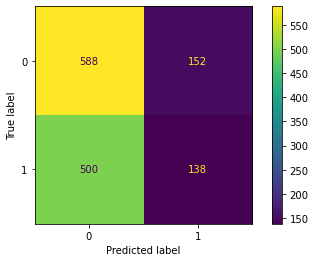

In [546]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

### Logistic Regression

In this case, the classification method of Logistic Regression performs well with an improved accuracy of 0.849. Of course, accuracy is not the only criteria to evaluate model. 

With regards to future work, more features could be investigated and calculated in the analysis. Also some deep learning techniques such as LSTM may be used for this time-series data.

In [547]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

C:\Users\shuan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8490566037735849

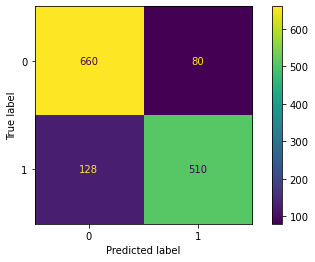

In [548]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

# Exersise 2

## Understand the dataset

This dataset contains 11 attributes, `ID`, `Group`, `Age`, `BMI`, `Gender`, `Smoker`, `Day`, `Block`, `HR`, `ACC`, `QI`. The data is collected from two groups, health control ('Control') and patients with a history of substance abuse ('Patient'), monitoring their average heart rate(`HR`) during the day and night. Apart from basic information such as `Age` and `Gender`, quality indicator (`QI`) is also recorded in the dataset.


From the information below showing the data structure and type, it is observed that most of the data is object and `HR`,`ACC` and `QI` are numerical data. When checking the missing values in the dataset, only the `Smoker` attribute has 45 null values which is filled with 'Na'.

In [607]:
data = pd.read_csv('Exercise 2/Heart_rate_DN.csv')

In [565]:
data

,ID,Group,Age,BMI,Gender,Smoker,Day,Block,HR,ACC,QI
0,2,Control,40-45,18-21,Female,No,0,Day,57,9.27,0.90
1,2,Control,40-45,18-21,Female,No,1,Night,49,9.52,0.93
2,2,Control,40-45,18-21,Female,No,1,Day,59,9.19,0.91
3,4,Control,30-35,24-27,Male,No,0,Day,76,10.07,0.98
4,4,Control,30-35,24-27,Male,No,1,Night,68,9.88,0.99
...,...,...,...,...,...,...,...,...,...,...,...
269,386,Patient,55-60,33-36,Female,No,0,Day,80,9.26,0.97
270,386,Patient,55-60,33-36,Female,No,1,Night,73,9.28,0.98
271,386,Patient,55-60,33-36,Female,No,1,Day,80,9.28,0.98
272,396,Patient,25-30,24-27,Female,Former smoker,1,Night,63,8.50,0.92


In [446]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      274 non-null    int64  
 1   Group   274 non-null    object 
 2   Age     274 non-null    object 
 3   BMI     274 non-null    object 
 4   Gender  274 non-null    object 
 5   Smoker  229 non-null    object 
 6   Day     274 non-null    int64  
 7   Block   274 non-null    object 
 8   HR      274 non-null    int64  
 9   ACC     274 non-null    float64
 10  QI      274 non-null    float64
dtypes: float64(2), int64(3), object(6)
memory usage: 23.7+ KB


In [447]:
data.describe()

,ID,Day,HR,ACC,QI
count,274.000000,274.000000,274.000000,274.000000,274.000000
mean,161.412409,1.784672,69.412409,9.352482,0.925876
std,113.422004,1.126269,14.034807,0.337429,0.146641
min,2.000000,0.000000,40.000000,8.500000,0.010000
25%,69.000000,1.000000,60.000000,9.130000,0.930000
50%,136.000000,2.000000,68.000000,9.350000,0.950000
75%,257.000000,3.000000,78.000000,9.560000,0.970000
max,396.000000,5.000000,119.000000,10.070000,0.990000


In [448]:
data.isna().sum()

ID         0
Group      0
Age        0
BMI        0
Gender     0
Smoker    45
Day        0
Block      0
HR         0
ACC        0
QI         0
dtype: int64

In [608]:
data=data.fillna('Na')
data.isna().sum()

ID        0
Group     0
Age       0
BMI       0
Gender    0
Smoker    0
Day       0
Block     0
HR        0
ACC       0
QI        0
dtype: int64

## Data exploratory

### data visualization

The plots below show the distribuition and density by `Age` and `Gender`, which is also shown by different groups. 

The original data of `Age` is replaced with numerical data using dic(). It is shown that the data are collected from the people with age ranging from 20 to 65+, and the distribution peaks at tweenties and forties. There is no obvious difference between 'Control' and 'Patient' groups.

For the `Gender` attribute,I encode it with a value 0 for female and 1 for male. In the group of 'Patient', there is more female than male.

In [609]:
# data["Age"].unique()
agedict = {
 '40-45':40, '30-35':30, '50-55':50, '55-60':55, '20-25':20, '25-30':25, '45-50':45,
       '35-40':35, '60-65':60, '65+':65
}

new_df=data
new_df['num_age']=data['Age'].apply(lambda x: agedict[x])

C:\Users\shuan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shuan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\shuan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shuan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot`

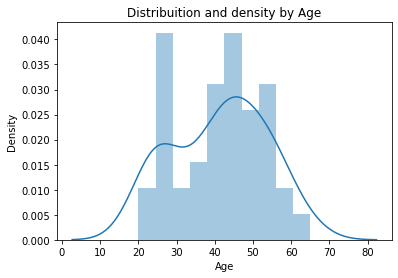

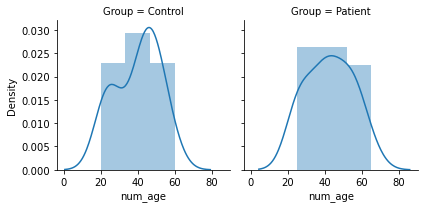

In [610]:
# Distribiution and density by Age
new_df = data.drop_duplicates(subset=['ID'],keep='first')
plt.figure(figsize=(6,4))
sns.distplot(new_df["num_age"], bins=10)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")

g = sns.FacetGrid(new_df, col='Group', size=3)
g = g.map(sns.distplot, "num_age")

<ipython-input-611-6ec87fa95a5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['num_Gender']=new_df['Gender'].apply(lambda x: 0 if x=='Female' else 1)
C:\Users\shuan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shuan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\shuan\Anaconda3\lib\site-packages\seabor

([<matplotlib.axis.XTick at 0x2923cb77610>,
 [Text(0, 0, 'Female'), Text(1, 0, 'Male'), Text(2, 0, '')])

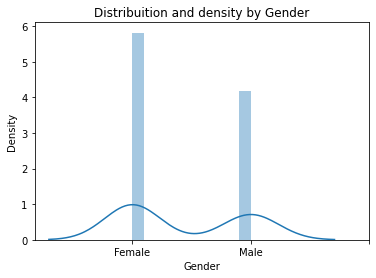

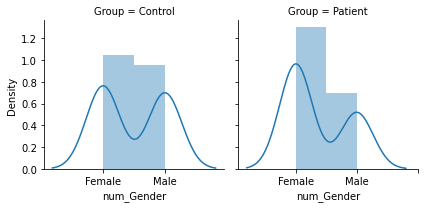

In [611]:
### Distribiution and density by Age
new_df['num_Gender']=new_df['Gender'].apply(lambda x: 0 if x=='Female' else 1)
plt.figure(figsize=(6,4))
sns.distplot(new_df["num_Gender"], bins=10)
plt.title("Distribuition and density by Gender")
plt.xlabel("Gender")
x = range(0,3,1)
plt.xticks(x, ('Female','Male',''))

g = sns.FacetGrid(new_df, col='Group', size=3)
g = g.map(sns.distplot, "num_Gender")
x = range(0,3,1)
plt.xticks(x, ('Female','Male',''))

### check outlier

There are extreme values (obvious outliers) in `QI` as shown in the plot below, which are all coming from the same person with an 'ID' of 69. Since there is limited amount of data, I replace those outliers with `QI` values randomly selected from the people in the same group with similar biological information, rather than excluding these data.

Text(0.5, 1.0, 'Box and Whiskers Plot')

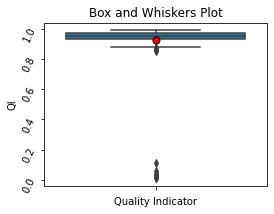

In [612]:
plt.rcParams["figure.figsize"] = (4,3)
sns.boxplot(y=data['QI'], showmeans = True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"7"})

plt.tick_params(labelrotation = 65)
plt.xlabel("Quality Indicator")
plt.title("Box and Whiskers Plot")

Text(0.5, 0, 'Heart Rate')

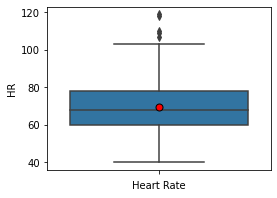

In [643]:
sns.boxplot(y=data['HR'], showmeans = True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"7"})
plt.xlabel("Heart Rate")


Text(0.5, 0, 'ACC')

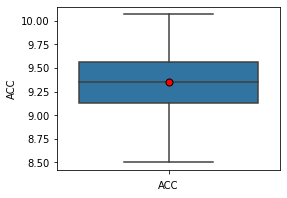

In [644]:
sns.boxplot(y=data['ACC'], showmeans = True, meanprops={"marker":"o",
                       "markerfacecolor":"red", 
                       "markeredgecolor":"black",
                      "markersize":"7"})
plt.xlabel("ACC")


In [452]:
data.loc[data['QI']<0.3]

,ID,Group,Age,BMI,Gender,Smoker,Day,Block,HR,ACC,QI
68,69,Control,40-45,18-21,Male,No,0,Day,74,9.98,0.03
69,69,Control,40-45,18-21,Male,No,1,Night,57,9.61,0.01
70,69,Control,40-45,18-21,Male,No,1,Day,73,10.00,0.11
71,69,Control,40-45,18-21,Male,No,2,Night,61,9.47,0.01
72,69,Control,40-45,18-21,Male,No,2,Day,66,9.87,0.04
73,69,Control,40-45,18-21,Male,No,3,Night,60,9.49,0.06
74,69,Control,40-45,18-21,Male,No,3,Day,67,9.80,0.02


In [613]:
data_QI=data.loc[(data['Group']=='Control')&((data['Age']=='40-45')|(data['Age']=='45-50'))]
data_QI=data_QI.drop(range(68,75))

In [614]:
QI_max=data_QI['QI'].max()
QI_min=data_QI['QI'].min()

In [615]:
#fill random value to the outliers  based on the other people's QI
rand=random.Random()

for i in range(68,75):
    data.iloc[i,-2]=round(rand.uniform(QI_min, QI_max),2)

### Some charts to see data relationship

I investigate the influence of `Block`, `Smoker`, `Gender` on `HR` in different groups by jitter plots. It should be noticed that the heart rate of group 'Patient' is larger and spreads more than the group 'Control', indicating that substance abuse could lead to higher heart rate with a larger spread. 

The heart rate during the day is large than that during night, which could be related to more activities during the day.

There is no clear impact of `Smoker` and `Gender` on `HR`.


In [457]:
def jitter(series, factor):
    a = float(factor)*0.2
    return series.apply(lambda x: x+np.random.uniform(-a,a))

In [594]:
df1 = data[(data['Group']=='Control')&(data['Block']=='Day')]
df1['index']=1
df1['index'] = jitter(df1['index'], 1)

df2 = data[(data['Group']=='Patient')&(data['Block']=='Day')]
df2['index']=2
df2['index'] = jitter(df2['index'], 1)

df3 = data[(data['Group']=='Control')&(data['Block']=='Night')]
df3['index']=1
df3['index'] = jitter(df3['index'], 1)

df4 = data[(data['Group']=='Patient')&(data['Block']=='Night')]
df4['index']=2
df4['index'] = jitter(df4['index'], 1)

([<matplotlib.axis.XTick at 0x2923171b9a0>,
 [Text(0, 0, '  '),
  Text(1, 0, 'Health Control'),
  Text(2, 0, 'Patient'),
  Text(3, 0, ' ')])

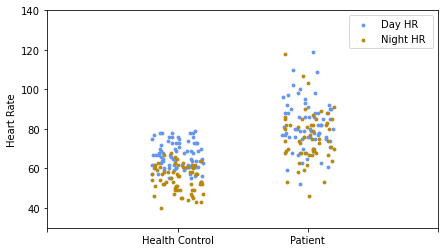

In [460]:
# f, axs = plt.subplots(2,1,figsize=(7,10))
# ax1 = plt.subplot(211)
l1=plt.scatter(df1['index'], df1['HR'],s=8,c='cornflowerblue')
l2=plt.scatter(df2['index'], df2['HR'],s=8,c='cornflowerblue')

x_min, x_max, y_min, y_max = 0, 3, 30,140
plt.axis([x_min, x_max, y_min, y_max])

# plt.ylabel('Day Heart Rate')
# plt.tick_params('x', labelbottom=False)
# # share x only
# ax2 = plt.subplot(212, sharey=ax1)

l3=plt.scatter(df3['index'], df3['HR'],s=8,c='darkgoldenrod')
l4=plt.scatter(df4['index'], df4['HR'],s=8,c='darkgoldenrod')

x_min, x_max, y_min, y_max = 0, 3, 30,140
# plt.axis([x_min, x_max, y_min, y_max])

plt.ylabel('Heart Rate')
plt.legend(handles=[l1,l3],labels=['Day HR','Night HR '],loc='best')

# make these tick labels invisible
x = range(0,4,1)
plt.xticks(x, ('  ','Health Control','Patient',' '))

In [461]:
data['Smoker'].unique()

array(['No', 'Na', 'Former smoker', 'Yes'], dtype=object)

In [590]:
df_smoke1 = data[(data['Group']=='Control')&((data['Smoker']=='No')|(data['Smoker']=='Former smoker'))]
df_smoke1['index']=1
df_smoke1['index'] = jitter(df_smoke1['index'], 1)

df_smoke2 = data[(data['Group']=='Patient')&(data['Smoker']=='No')]
df_smoke2['index']=2
df_smoke2['index'] = jitter(df_smoke2['index'], 1)

In [591]:
df_smoke3 = data[(data['Group']=='Control')&(data['Smoker']=='Yes')]
df_smoke3['index']=1
df_smoke3['index'] = jitter(df_smoke3['index'], 1)

df_smoke4 = data[(data['Group']=='Patient')&(data['Smoker']=='Yes')]
df_smoke4['index']=2
df_smoke4['index'] = jitter(df_smoke4['index'], 1)

([<matplotlib.axis.XTick at 0x29231796a30>,
 [Text(0, 0, '  '),
  Text(1, 0, 'Health Control'),
  Text(2, 0, 'Patient'),
  Text(3, 0, ' ')])

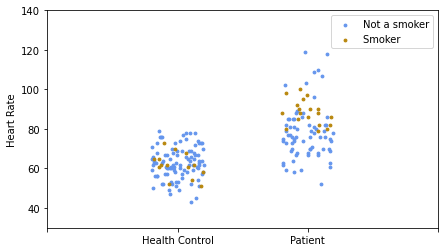

In [464]:
# ax1 = plt.subplot(211)
l1=plt.scatter(df_smoke1['index'], df_smoke1['HR'],s=8,c='cornflowerblue')
l2=plt.scatter(df_smoke2['index'], df_smoke2['HR'],s=8,c='cornflowerblue')

x_min, x_max, y_min, y_max = 0, 3, 30,140
plt.axis([x_min, x_max, y_min, y_max])

# plt.ylabel('Day Heart Rate')
# plt.tick_params('x', labelbottom=False)
# # share x only
# ax2 = plt.subplot(212, sharey=ax1)

l3=plt.scatter(df_smoke3['index'], df_smoke3['HR'],s=8,c='darkgoldenrod')
l4=plt.scatter(df_smoke4['index'], df_smoke4['HR'],s=8,c='darkgoldenrod')

x_min, x_max, y_min, y_max = 0, 3, 30,140
# plt.axis([x_min, x_max, y_min, y_max])

plt.ylabel('Heart Rate')
plt.legend(handles=[l1,l3],labels=['Not a smoker','Smoker '],loc='best')

# make these tick labels invisible
x = range(0,4,1)
plt.xticks(x, ('  ','Health Control','Patient',' '))

In [592]:
df_gender = data[(data['Group']=='Control')&(data['Gender']=='Female')]
df_gender['index']=1
df_gender['index'] = jitter(df_gender['index'], 1)

df_gender2 = data[(data['Group']=='Patient')&(data['Gender']=='Female')]
df_gender2['index']=2
df_gender2['index'] = jitter(df_gender2['index'], 1)

df_gender3 = data[(data['Group']=='Control')&(data['Gender']=='Male')]
df_gender3['index']=1
df_gender3['index'] = jitter(df_gender3['index'], 1)

df_gender4 = data[(data['Group']=='Patient')&(data['Gender']=='Male')]
df_gender4['index']=2
df_gender4['index'] = jitter(df_gender4['index'], 1)


([<matplotlib.axis.XTick at 0x2923655edc0>,
 [Text(0, 0, '  '),
  Text(1, 0, 'Health Control'),
  Text(2, 0, 'Patient'),
  Text(3, 0, ' ')])

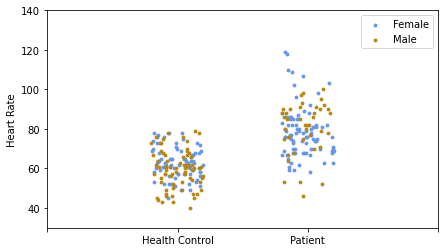

In [522]:
# ax1 = plt.subplot(211)
l1=plt.scatter(df_gender['index'], df_gender['HR'],s=8,c='cornflowerblue')
l2=plt.scatter(df_gender2['index'], df_gender2['HR'],s=8,c='cornflowerblue')

x_min, x_max, y_min, y_max = 0, 3, 30,140
plt.axis([x_min, x_max, y_min, y_max])

# plt.ylabel('Day Heart Rate')
# plt.tick_params('x', labelbottom=False)
# # share x only
# ax2 = plt.subplot(212, sharey=ax1)

l3=plt.scatter(df_gender3['index'], df_gender3['HR'],s=8,c='darkgoldenrod')
l4=plt.scatter(df_gender4['index'], df_gender4['HR'],s=8,c='darkgoldenrod')

x_min, x_max, y_min, y_max = 0, 3, 30,140
# plt.axis([x_min, x_max, y_min, y_max])

plt.ylabel('Heart Rate')
plt.legend(handles=[l1,l3],labels=['Female','Male '],loc='best')

# make these tick labels invisible
x = range(0,4,1)
plt.xticks(x, ('  ','Health Control','Patient',' '))

([<matplotlib.axis.XTick at 0x292362c7220>,
 [Text(0, 0, '  '),
  Text(1, 0, 'Health Control'),
  Text(2, 0, 'Patient'),
  Text(3, 0, ' ')])

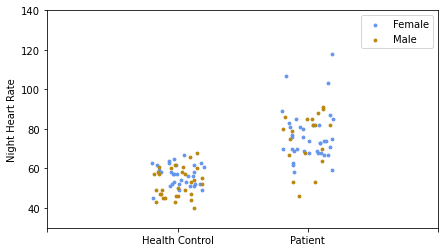

In [519]:
# ax1 = plt.subplot(211)
l1=plt.scatter(df_gender['index'], df_gender['HR'],s=8,c='cornflowerblue')
l2=plt.scatter(df_gender2['index'], df_gender2['HR'],s=8,c='cornflowerblue')

x_min, x_max, y_min, y_max = 0, 3, 30,140
plt.axis([x_min, x_max, y_min, y_max])

# plt.ylabel('Day Heart Rate')
# plt.tick_params('x', labelbottom=False)
# # share x only
# ax2 = plt.subplot(212, sharey=ax1)

l3=plt.scatter(df_gender3['index'], df_gender3['HR'],s=8,c='darkgoldenrod')
l4=plt.scatter(df_gender4['index'], df_gender4['HR'],s=8,c='darkgoldenrod')

x_min, x_max, y_min, y_max = 0, 3, 30,140
# plt.axis([x_min, x_max, y_min, y_max])

plt.ylabel('Night Heart Rate')
plt.legend(handles=[l1,l3],labels=['Female','Male '],loc='best')

# make these tick labels invisible
x = range(0,4,1)
plt.xticks(x, ('  ','Health Control','Patient',' '))

No significant correlation between heart rate and `ACC`, while there is a postive correlation between heart rate and quality indicator. 

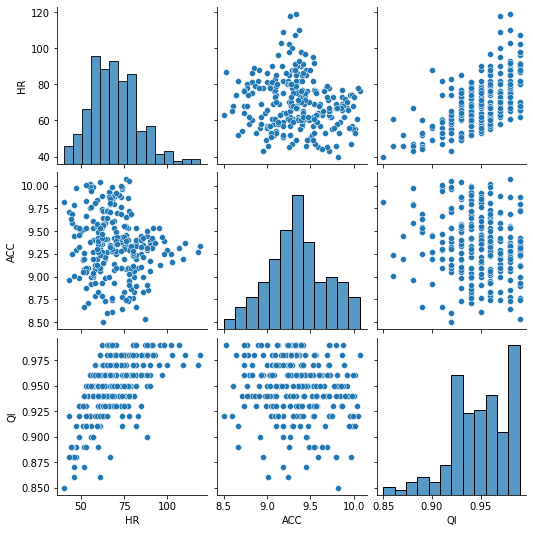

In [620]:
AQ_data=data[['HR','ACC','QI']]

sns.pairplot(AQ_data)

### one-hot encoding

The attributes `Group`, `Age`, `BMI`, `Gender`, `Smoker`, `Block` are applied with one hot encoding in order to convert object to numerical value. The correlation plot is based on the one hot data. The attribute `Day` is excluded and not be considered in the model training since it has the least correlation with heart rate according to the correlation.

In [645]:
one_hot_data = pd.get_dummies(data,columns=['Group', 'Day','Age', 'BMI', 'Gender', 'Smoker', 'Block'],drop_first=True)

In [646]:
one_hot_data

,ID,HR,ACC,QI,num_age,Group_1,Day_1,Day_2,Day_3,Day_4,...,BMI_2,BMI_3,BMI_4,BMI_5,BMI_6,Gender_1,Smoker_1,Smoker_2,Smoker_3,Block_1
0,2,57,9.27,0.90,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,49,9.52,0.93,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,2,59,9.19,0.91,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,76,10.07,0.98,30,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,4,68,9.88,0.99,30,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,386,80,9.26,0.97,55,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
270,386,73,9.28,0.98,55,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
271,386,80,9.28,0.98,55,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
272,396,63,8.50,0.92,25,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [647]:
one_hot_data.columns

Index(['ID', 'HR', 'ACC', 'QI', 'num_age', 'Group_1', 'Day_1', 'Day_2',
       'Day_3', 'Day_4', 'Day_5', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Age_5',
       'Age_6', 'Age_7', 'Age_8', 'Age_9', 'BMI_1', 'BMI_2', 'BMI_3', 'BMI_4',
       'BMI_5', 'BMI_6', 'Gender_1', 'Smoker_1', 'Smoker_2', 'Smoker_3',
       'Block_1'],
      dtype='object')

<AxesSubplot:>

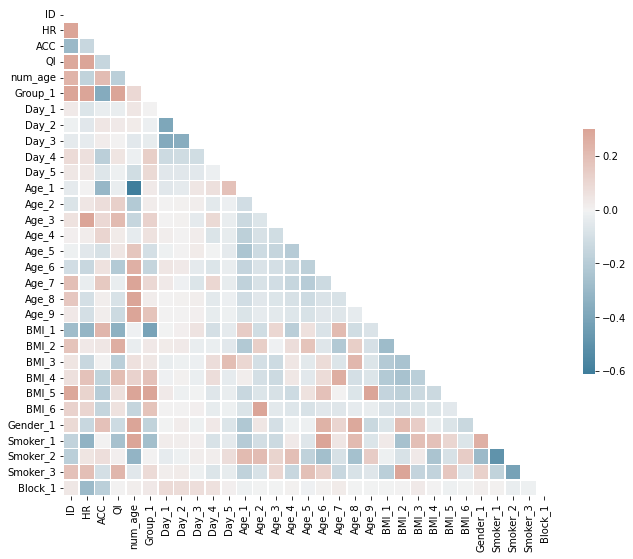

In [648]:
corr = one_hot_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


## Baseline

Apply linear regression to the model as baseline. The used evaluation method mean quared error is 0.23 which is small.

In [641]:
# define X and y
feature_cols = ['ID','ACC', 'QI', 'num_age', 'Group_1', 'Age_1', 'Age_2',
       'Age_3', 'Age_4', 'Age_5', 'Age_6', 'Age_7', 'Age_8', 'Age_9', 'BMI_1',
       'BMI_2', 'BMI_3', 'BMI_4', 'BMI_5', 'BMI_6', 'Gender_1', 'Smoker_1',
       'Smoker_2', 'Smoker_3', 'Block_1']
X = one_hot_data[feature_cols]
y = one_hot_data['HR']


# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

y_train_std = (y_train - y_train.mean()) / y_train.std()
y_test_std = (y_test - y_train.mean()) / y_train.std()

In [642]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train_std, y_train_std)

y_test_std_pred = regr.predict(X_test_std)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_std_pred,y_test_std)

0.23394944822358024